# Распознавание писателей

## Подготовка данных

### Import библиотек

In [ ]:
from google.colab import files #модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных
import pandas as pd #библиотека для обработки и анализа данных
import matplotlib.pyplot as plt #библиотека для визуализации данных
# "Магическая"команда python для запуска библиотеки в ноутбуке
%matplotlib inline

from tensorflow.keras import utils #модуль с утилитами кераса, будем использовать для вызова метода преобразования категорий в вектора
from tensorflow.keras.models import Sequential #последовательная модель нейросети кераса
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
# Загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов

from keras.preprocessing.text import Tokenizer, text_to_word_sequence #инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split #модуль для разбиения данных на обучающую и тестовую выборки
from tensorflow.keras.utils import plot_model
import seaborn as sns
sns.set_style('darkgrid')
import time # Импортируем библиотеку time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Загрузка данных


In [ ]:
# Чтение файла в текст

def readText(fileName): # функция принимает имя файла
  f = open(fileName, 'r')        # задаем открытие нужного файла в режиме чтения
  text = f.read()                # читаем текст
  text = text.replace("\n", " ") # переносы строки переводим в пробелы
  
  return text                    # функция возвращает текст файла

# Загружаем обучающие тексты
Text = []
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Беляев.txt'))
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Булгаков.txt'))
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Васильев.txt'))
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Гоголь.txt'))
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Гончаров.txt'))
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Горький.txt')) 
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Грибоедов.txt')) 
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Достоевский.txt')) 
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Каверин.txt')) 
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Катаев.txt')) 
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Куприн.txt')) 
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Лермонтов.txt')) 
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Лесков.txt')) 
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Носов.txt')) 
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Пастернак.txt')) 
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Пушкин.txt')) 
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Толстой.txt')) 
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Тургенев.txt')) 
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Чехов.txt')) 
Text.append(readText('/content/drive/MyDrive/Базы/Русские писатели/Шолохов.txt')) 

className = ["Беляев", "Булгаков", "Васильев", "Гоголь", "Гончаров", "Горький", "Грибоедов", "Достоевский", "Каверин", "Катаев", "Куприн", "Лермонтов", "Лесков", "Носов", "Пастернак", "Пушкин", "Толстой", "Тургенев", "Чехов", "Шолохов"]
nClasses = len(className)


In [ ]:
Text[0]

In [ ]:
print(len(Text))


20


In [ ]:
#Получаем обучающую и тестовую выборки
def get_test_train(text):
    x_train=[]
    x_test =[]

    for i in range(len(text)):
        text_tr,text_test =train_test_split(text[i].split(),test_size=0.1, shuffle = False) # Делим текст на выборки
        x_train.append(' '.join(text_tr))      
        x_test.append(' '.join(text_test))      
    return x_train, x_test

x_train, x_test = get_test_train(Text)

In [ ]:
maxWordsCount = 500 # определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(x_train)          # даём тексты в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # вытаскиваем индексы слов для просмотра

In [ ]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(x_train) # обучающие тексты в индексы
testWordIndexes = tokenizer.texts_to_sequences(x_test)   # проверочные тексты в индексы

In [ ]:
# формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  
  # идём по всей длине вектора индексов
  # "откусываем" векторы длины xLen и смещаеммся вперёд на step
  
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample

  
# формирование обучающей и проверочной выборки
# из двух листов индексов от двух классов

def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # для каждого из 6 классов создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов выборки
  classesXSamples = []        # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # формируем один общий xSamples
  xSamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses):   # в диапазоне кол-ва классов (6)
    xT = classesXSamples[t]   # берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)):  # и каждое его окно
      xSamples.append(xT[i])  # добавляем в общий список выборки
    
    # формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 6 вида [0.0.0.1.0.0.]
    for i in range(len(xT)):  # на каждое окно выборки 
      ySamples.append(currY)  # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку
  
  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

In [ ]:
# задаём базовые параметры
xLen = 500 # длина отрезка текста, по которой анализируем, в словах
step = 10  # шаг разбиения исходного текста на обучающие вектора

In [ ]:
# формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
# получили обучающий/тестовый набор, достаточный для запуска Embedding, 
# но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1

(779171, 500)
(779171, 20)
(85722, 500)
(85722, 20)


In [ ]:
#
# Представляем тестовую выборку в удобных для распознавания размерах
#
def createTestMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов
  xTest6Classes01 = []               # здесь будет список из всех классов,каждый размером "кол-во окон в тексте * 500(при maxWordsCount=500)"
  xTest6Classes = []                 # здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(10 по 420*1000)
  for wI in wordIndexes:             # для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) # тестовая выборка размером "кол-во окон*длину окна"(например 420*1000)
    xTest6Classes.append(np.array(sample))       # переводим в массив numpy и добавляем в список
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) # трансформируется в Bag of Words в виде "кол-во окон в тексте * 500"
  xTest6Classes01 = np.array(xTest6Classes01)                     # и добавляется к нашему списку, 
  
  return xTest6Classes01, xTest6Classes # функция вернёт тестовые данные: TestBg 10 классов на n*500 и xTestEm 10 по n*1000

#
# Расспознаём тестовую выборку и выводим результаты
#
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  val = []
  pred = []
  
  totalSumRec = []
  
  # Проходим по всем классам
  for i in range(nClasses):
    # Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    # Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)
    
    # Считаем процент распознавания каждого класса за каждый
    # Получам матрицу 6 на 6
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))
    
    totalSumRec.append(sumRec[i])
    
    # Определяем, какой в класс в итоге за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)
    
    # Выводим результаты распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)
  
  # Выводим вредний процент распознавания по всем классам вместе
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
  print()
  return sumVal/sumCount

xTest6Classes01, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) # подгоним форму тестовых классов под функцию recognizeMultiClass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


## Эксперименты

Bag of Words

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 20)                4020      
                                                                 
Total params: 106,220
Trainable params: 105,220
Non-trainable params: 1,000
_________________________________________________________________



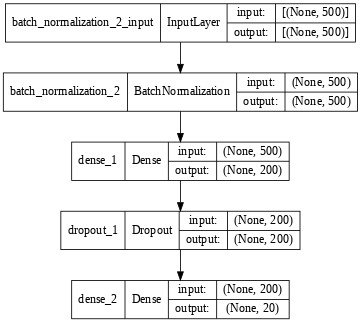

In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()
#Первый полносвязный слой
model01.add(BatchNormalization(input_dim=maxWordsCount))
model01.add(Dense(200, activation="relu"))
model01.add(Dropout(0.5))
#Выходной полносвязный слой
model01.add(Dense(20, activation='sigmoid'))

model01.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model01.summary()
print()
plot_model(model01, dpi=60, show_shapes=True) # Выводим схему модели

In [ ]:
#Обучаем сеть на выборке, сформированной по bag of words - xTrain
history = model01.fit(xTrain, yTrain, epochs=10, batch_size=1000, validation_data=(xTest, yTest))

Epoch 1/10
780/780 [==============================] - 8s 9ms/step - loss: 2.8609 - accuracy: 0.1435 - val_loss: 2.8150 - val_accuracy: 0.1706
Epoch 2/10
780/780 [==============================] - 6s 8ms/step - loss: 2.7581 - accuracy: 0.1628 - val_loss: 2.8105 - val_accuracy: 0.1704
Epoch 3/10
780/780 [==============================] - 6s 8ms/step - loss: 2.7474 - accuracy: 0.1653 - val_loss: 2.8222 - val_accuracy: 0.1706
Epoch 4/10
780/780 [==============================] - 6s 8ms/step - loss: 2.7409 - accuracy: 0.1669 - val_loss: 2.8211 - val_accuracy: 0.1702
Epoch 5/10
780/780 [==============================] - 6s 8ms/step - loss: 2.7354 - accuracy: 0.1681 - val_loss: 2.8222 - val_accuracy: 0.1687
Epoch 6/10
780/780 [==============================] - 6s 8ms/step - loss: 2.7320 - accuracy: 0.1691 - val_loss: 2.8268 - val_accuracy: 0.1702
Epoch 7/10
780/780 [==============================] - 6s 8ms/step - loss: 2.7290 - accuracy: 0.1699 - val_loss: 2.8382 - val_accuracy: 0.1693
Epoch 

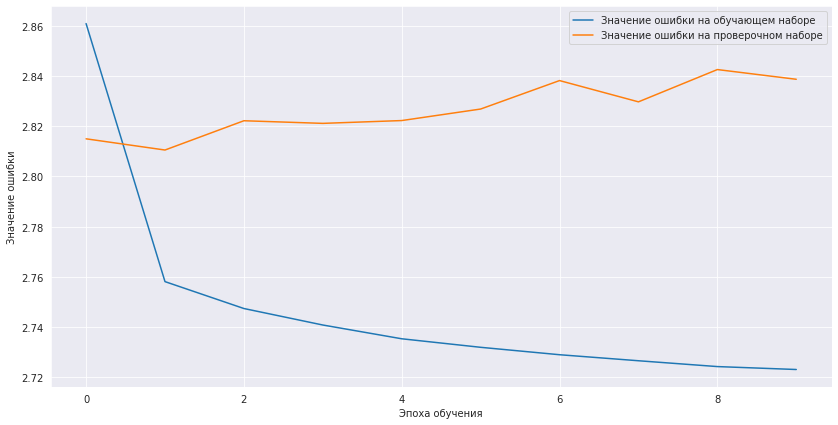

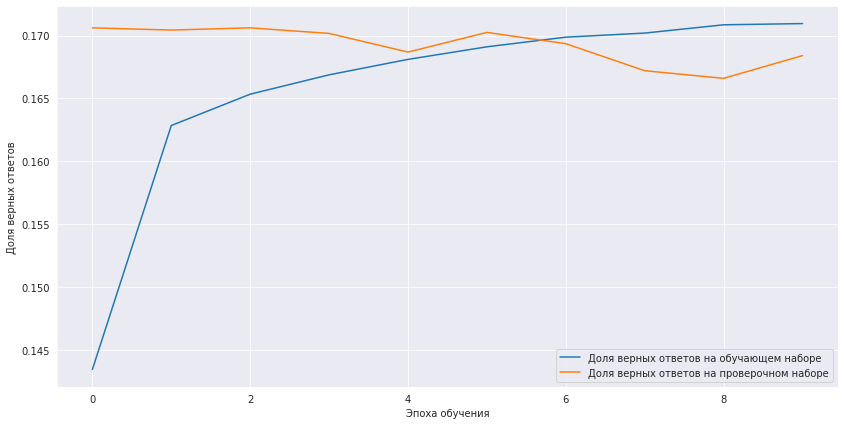

In [ ]:
# Строим график отображения динамики ошибки работы модели
plt.figure(figsize = (14,7))
plt.plot(history.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# График отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14,7))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred=recognizeMultiClass(model01, xTest6Classes, 'ED') # функция покажет, какие классы и как распознаны верно

НЕЙРОНКА:  ED

Беляев  распознано  0 % сеть считает, что это  Чехов ,  распознано НЕ ВЕРНО!
Булгаков  распознано  0 % сеть считает, что это  Чехов ,  распознано НЕ ВЕРНО!
Васильев  распознано  0 % сеть считает, что это  Чехов ,  распознано НЕ ВЕРНО!
Гоголь  распознано  0 % сеть считает, что это  Достоевский ,  распознано НЕ ВЕРНО!
Гончаров  распознано  0 % сеть считает, что это  Чехов ,  распознано НЕ ВЕРНО!
Горький  распознано  0 % сеть считает, что это  Чехов ,  распознано НЕ ВЕРНО!
Грибоедов  распознано  0 % сеть считает, что это  Чехов ,  распознано НЕ ВЕРНО!
Достоевский  распознано  68 % сеть считает, что это  Достоевский ,  распознано ВЕРНО!
Каверин  распознано  0 % сеть считает, что это  Чехов ,  распознано НЕ ВЕРНО!
Катаев  распознано  0 % сеть считает, что это  Шолохов ,  распознано НЕ ВЕРНО!
Куприн  распознано  0 % сеть считает, что это  Чехов ,  распознано НЕ ВЕРНО!
Лермонтов  распознано  2 % сеть считает, что это  Достоевский ,  распознано НЕ ВЕРНО!
Лесков  распознано  0 % 

Embedding

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 20)           10000     
                                                                 
 batch_normalization_1 (Batc  (None, 500, 20)          80        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 500, 20)           0         
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 20)                200020    
                                                                 
Total params: 210,100
Trainable params: 210,060
Non-trainable params: 40
_______________________________________________

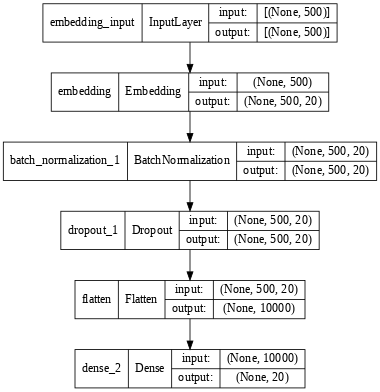

In [ ]:
modelED = Sequential()
modelED.add(Embedding(maxWordsCount, 20, input_length=xLen))
modelED.add(BatchNormalization())
modelED.add(Dropout(0.25))
modelED.add(Flatten())
modelED.add(Dense (20, activation="softmax"))

modelED.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

modelED.summary()
print()
plot_model(modelED, dpi=60, show_shapes=True) # Выводим схему модели

In [ ]:
history = modelED.fit(xTrain,
                      yTrain,
                      epochs=10,
                      batch_size=512,
                      validation_data=(xTest, yTest))

Epoch 1/10
1522/1522 [==============================] - 35s 22ms/step - loss: 0.8248 - accuracy: 0.7395 - val_loss: 1.0318 - val_accuracy: 0.7205
Epoch 2/10
1522/1522 [==============================] - 33s 21ms/step - loss: 0.5045 - accuracy: 0.8344 - val_loss: 1.1038 - val_accuracy: 0.7009
Epoch 3/10
1522/1522 [==============================] - 32s 21ms/step - loss: 0.4617 - accuracy: 0.8464 - val_loss: 1.0043 - val_accuracy: 0.7293
Epoch 4/10
1522/1522 [==============================] - 33s 22ms/step - loss: 0.4383 - accuracy: 0.8531 - val_loss: 1.0468 - val_accuracy: 0.7216
Epoch 5/10
1522/1522 [==============================] - 32s 21ms/step - loss: 0.4219 - accuracy: 0.8584 - val_loss: 0.9904 - val_accuracy: 0.7391
Epoch 6/10
1522/1522 [==============================] - 32s 21ms/step - loss: 0.4109 - accuracy: 0.8619 - val_loss: 1.1420 - val_accuracy: 0.7080
Epoch 7/10
1522/1522 [==============================] - 32s 21ms/step - loss: 0.3998 - accuracy: 0.8650 - val_loss: 1.0060 -

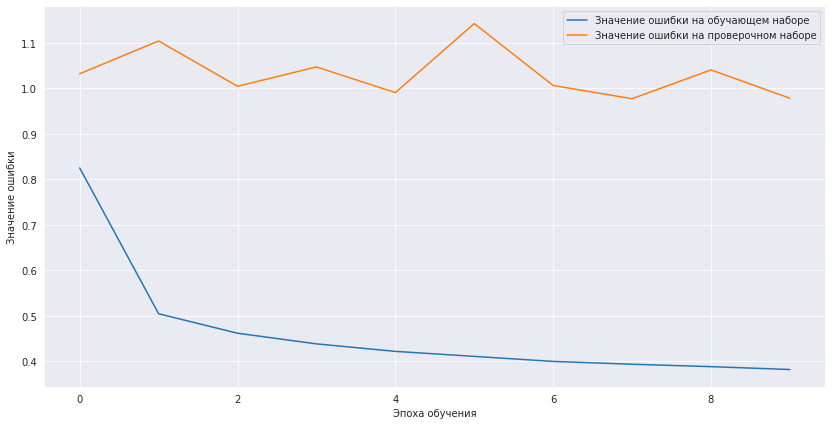

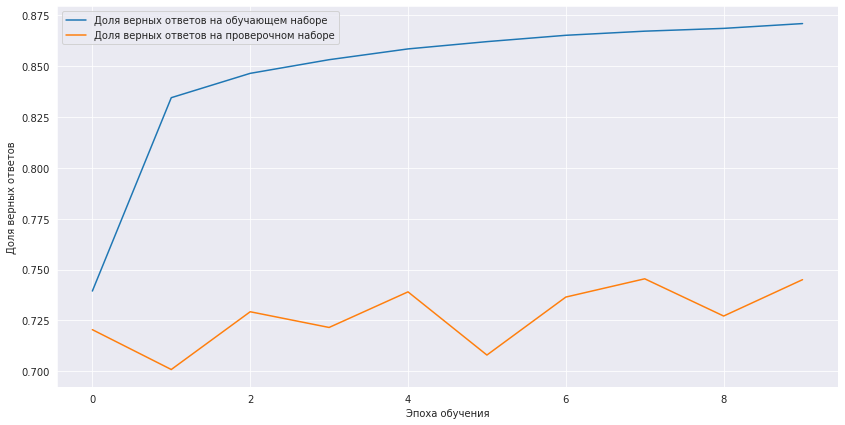

In [ ]:
# Строим график отображения динамики ошибки работы модели
plt.figure(figsize = (14,7))
plt.plot(history.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# График отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14,7))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred=recognizeMultiClass(modelED, xTest6Classes, 'ED') # функция покажет, какие классы и как распознаны верно

НЕЙРОНКА:  ED

Беляев  распознано  65 % сеть считает, что это  Беляев ,  распознано ВЕРНО!
Булгаков  распознано  76 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Васильев  распознано  91 % сеть считает, что это  Васильев ,  распознано ВЕРНО!
Гоголь  распознано  49 % сеть считает, что это  Гоголь ,  распознано ВЕРНО!
Гончаров  распознано  87 % сеть считает, что это  Гончаров ,  распознано ВЕРНО!
Горький  распознано  67 % сеть считает, что это  Горький ,  распознано ВЕРНО!
Грибоедов  распознано  73 % сеть считает, что это  Грибоедов ,  распознано ВЕРНО!
Достоевский  распознано  66 % сеть считает, что это  Достоевский ,  распознано ВЕРНО!
Каверин  распознано  84 % сеть считает, что это  Каверин ,  распознано ВЕРНО!
Катаев  распознано  81 % сеть считает, что это  Катаев ,  распознано ВЕРНО!
Куприн  распознано  63 % сеть считает, что это  Куприн ,  распознано ВЕРНО!
Лермонтов  распознано  52 % сеть считает, что это  Лермонтов ,  распознано ВЕРНО!
Лесков  распознано  65 % сеть счита

### LSTM

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 25)           12500     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 500, 25)          0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_1 (Batc  (None, 500, 25)          100       
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 20)                3680      
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
Total params: 16,700
Trainable params: 16,650
Non-trai

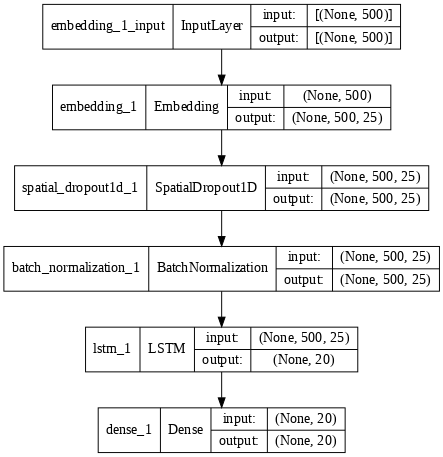

In [ ]:
model_LSTM = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM.add(Embedding(maxWordsCount, 25, input_length=xLen))

model_LSTM.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM.add(LSTM(20))
model_LSTM.add(Dense(20, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM.summary()
print()
plot_model(model_LSTM, dpi=70, show_shapes=True) # Выводим схему модели

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/10
1522/1522 [==============================] - 135s 85ms/step - loss: 2.6320 - accuracy: 0.2055 - val_loss: 2.5219 - val_accuracy: 0.2393
Epoch 2/10
1522/1522 [==============================] - 129s 85ms/step - loss: 2.4719 - accuracy: 0.2599 - val_loss: 2.3081 - val_accuracy: 0.2967
Epoch 3/10
1522/1522 [==============================] - 127s 83ms/step - loss: 2.2219 - accuracy: 0.3379 - val_loss: 2.1495 - val_accuracy: 0.3649
Epoch 4/10
1522/1522 [==============================] - 127s 83ms/step - loss: 1.8058 - accuracy: 0.4373 - val_loss: 1.6475 - val_accuracy: 0.4948
Epoch 5/10
1522/1522 [==============================] - 127s 84ms/step - loss: 1.2934 - accuracy: 0.5876 - val_loss: 1.3623 - val_accuracy: 0.5764
Epoch 6/10
1522/1522 [==============================] - 127s 84ms/step - loss: 0.9711 - accuracy: 0.6884 - val_loss: 1.2285 - val_accuracy: 0.6279
Epoch 7/10
1522/1522 [==============================] - 127s 84ms/step - loss: 0.8132 - accuracy: 0.7373 - val_loss: 1

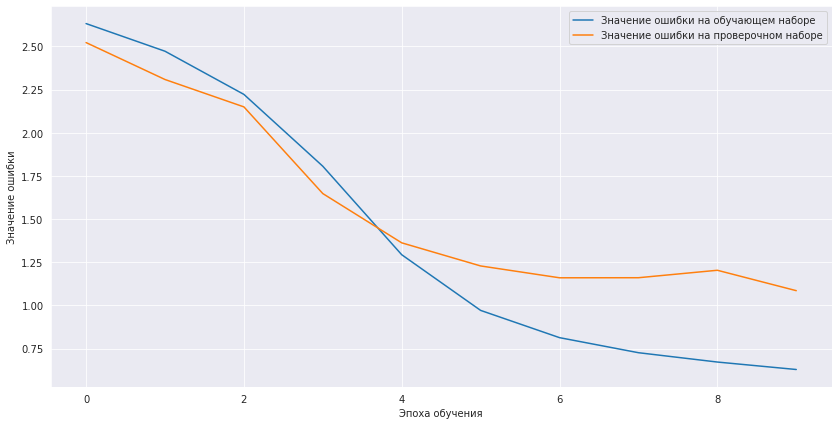

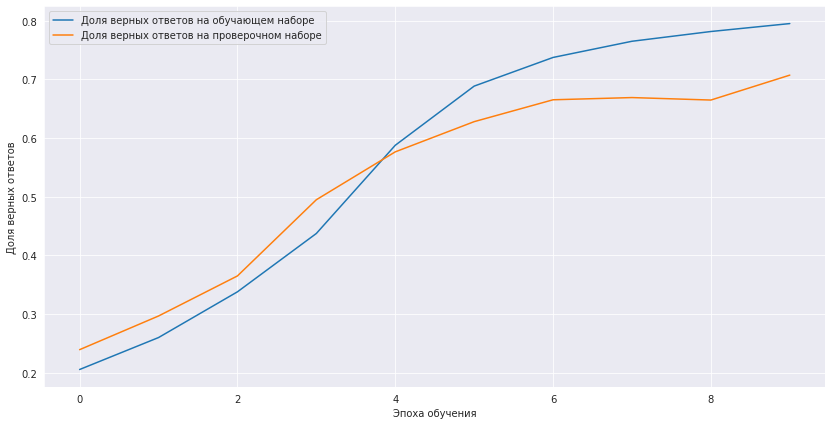

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred=recognizeMultiClass(model_LSTM, xTest6Classes, 'LSTM') # функция покажет, какие классы и как распознаны верно

НЕЙРОНКА:  LSTM

Беляев  распознано  72 % сеть считает, что это  Беляев ,  распознано ВЕРНО!
Булгаков  распознано  69 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Васильев  распознано  95 % сеть считает, что это  Васильев ,  распознано ВЕРНО!
Гоголь  распознано  27 % сеть считает, что это  Пушкин ,  распознано НЕ ВЕРНО!
Гончаров  распознано  72 % сеть считает, что это  Гончаров ,  распознано ВЕРНО!
Горький  распознано  42 % сеть считает, что это  Горький ,  распознано ВЕРНО!
Грибоедов  распознано  77 % сеть считает, что это  Грибоедов ,  распознано ВЕРНО!
Достоевский  распознано  78 % сеть считает, что это  Достоевский ,  распознано ВЕРНО!
Каверин  распознано  78 % сеть считает, что это  Каверин ,  распознано ВЕРНО!
Катаев  распознано  56 % сеть считает, что это  Катаев ,  распознано ВЕРНО!
Куприн  распознано  47 % сеть считает, что это  Куприн ,  распознано ВЕРНО!
Лермонтов  распознано  61 % сеть считает, что это  Лермонтов ,  распознано ВЕРНО!
Лесков  распознано  53 % сеть 

### Conv1D

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 20)           10000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 500, 20)          0         
 ropout1D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 500, 20)          80        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 500, 20)           2020      
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 20)           2020      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 248, 20)          0

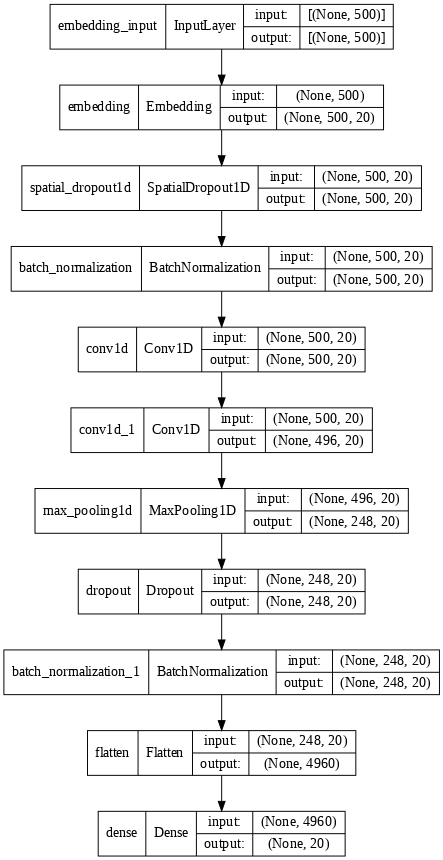

In [ ]:
model_Conv_1 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Conv_1.add(Embedding(maxWordsCount, 20, input_length=xLen))

model_Conv_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Conv_1.add(BatchNormalization())  # добавляем слой нормализации данных
model_Conv_1.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_1.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_1.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_1.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Conv_1.add(Dense(20, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Conv_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Conv_1.summary()
print()
plot_model(model_Conv_1, dpi=70, show_shapes=True)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Conv_1.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=1000,
                    validation_data=(xTest, yTest))

Epoch 1/10
780/780 [==============================] - 77s 86ms/step - loss: 1.3450 - accuracy: 0.5806 - val_loss: 1.3015 - val_accuracy: 0.6240
Epoch 2/10
780/780 [==============================] - 66s 85ms/step - loss: 0.7349 - accuracy: 0.7570 - val_loss: 1.3108 - val_accuracy: 0.6608
Epoch 3/10
780/780 [==============================] - 66s 85ms/step - loss: 0.6402 - accuracy: 0.7876 - val_loss: 1.0656 - val_accuracy: 0.7053
Epoch 4/10
780/780 [==============================] - 66s 85ms/step - loss: 0.5901 - accuracy: 0.8034 - val_loss: 1.1603 - val_accuracy: 0.6862
Epoch 5/10
780/780 [==============================] - 66s 84ms/step - loss: 0.5626 - accuracy: 0.8125 - val_loss: 1.3932 - val_accuracy: 0.6537
Epoch 6/10
780/780 [==============================] - 66s 85ms/step - loss: 0.5409 - accuracy: 0.8192 - val_loss: 1.1459 - val_accuracy: 0.6889
Epoch 7/10
780/780 [==============================] - 67s 85ms/step - loss: 0.5245 - accuracy: 0.8239 - val_loss: 1.2812 - val_accuracy:

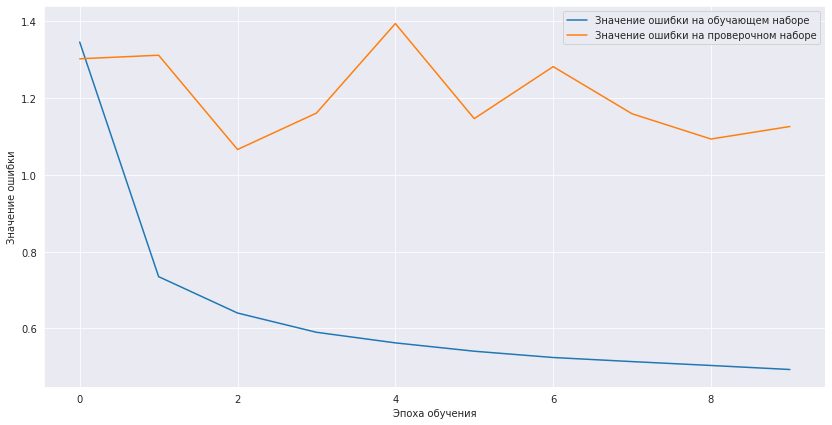

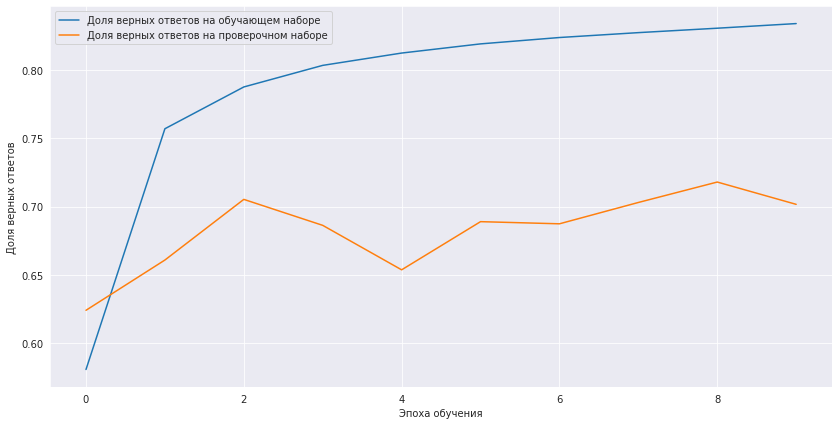

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred=recognizeMultiClass(model_Conv_1, xTest6Classes, 'ED') # функция покажет, какие классы и как распознаны верно

НЕЙРОНКА:  ED

Беляев  распознано  66 % сеть считает, что это  Беляев ,  распознано ВЕРНО!
Булгаков  распознано  70 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Васильев  распознано  89 % сеть считает, что это  Васильев ,  распознано ВЕРНО!
Гоголь  распознано  43 % сеть считает, что это  Гоголь ,  распознано ВЕРНО!
Гончаров  распознано  92 % сеть считает, что это  Гончаров ,  распознано ВЕРНО!
Горький  распознано  65 % сеть считает, что это  Горький ,  распознано ВЕРНО!
Грибоедов  распознано  79 % сеть считает, что это  Грибоедов ,  распознано ВЕРНО!
Достоевский  распознано  55 % сеть считает, что это  Достоевский ,  распознано ВЕРНО!
Каверин  распознано  55 % сеть считает, что это  Каверин ,  распознано ВЕРНО!
Катаев  распознано  66 % сеть считает, что это  Катаев ,  распознано ВЕРНО!
Куприн  распознано  49 % сеть считает, что это  Куприн ,  распознано ВЕРНО!
Лермонтов  распознано  48 % сеть считает, что это  Лермонтов ,  распознано ВЕРНО!
Лесков  распознано  63 % сеть счита

Точность моделей на 10 эпохах оказалась следующая:
1. Подход Bag of Words показал 16,84% сразу уходит в переобучение. Хотя на него была основная надежда на опыте предыдущих моделей. Нет смысла бороться за результаты при такой архитектуре.
2. Embedding 74,5 % лучший результат на 10 эпохах, но нет сильной тенденции роста точности. Переобучения нет. Варианты подбора конфигурации и гиперпараметров, возможно могут улучшить точность модели.
3. LSTM. Точность 70,71%. Стартовал с низких значений и демонстрировал стабильный рост точности в процессе обучения. Вероятно добавление количества эпох даст позитивный вариант. На переобучение нет даже намека. В дальнейшем, с калибровкой архитектуры и гиперпараметров способна быть лидером точности.
4. Cond1D. Точность 70,16 %. Стартовала с неплохих уровней, слегка добавила с приличной пилой. Возможно подбор архитектуры, гиперпараметров и снижение lr могут еще немного повысить точность.

Общий вывод: при обработке большого объема и приличного количества классов Bag of Words показал не такую высокую эффективность, как при небольших объемах данных, зато включение в архитектуру слоев Embedding, их дополнение слоями LSTM или Conv1D способно показать в таких условиях более высокую эффективность.

Вывод № 2. Для схожих задач (например классификация текстовых данных) в зависимости от параметров данных разные архитектуры могут показывать разную эффективность, отличающуюся от полученной на схожих задачах, поэтому необходимо тестирование работоспособности различных моделей архитектуры нейронных сетей.